Epoch 1/100 - Loss: 34.2486
Epoch 2/100 - Loss: 0.9998
Epoch 3/100 - Loss: 0.6651
Epoch 4/100 - Loss: 0.4454
Epoch 5/100 - Loss: 0.3318
Epoch 6/100 - Loss: 0.2984
Epoch 7/100 - Loss: 0.3060
Epoch 8/100 - Loss: 0.2598
Epoch 9/100 - Loss: 0.2521
Epoch 10/100 - Loss: 0.2408
Epoch 11/100 - Loss: 0.2493
Epoch 12/100 - Loss: 0.2428
Epoch 13/100 - Loss: 0.2461
Epoch 14/100 - Loss: 0.2395
Epoch 15/100 - Loss: 0.2558
Epoch 16/100 - Loss: 0.2272
Epoch 17/100 - Loss: 0.2804
Epoch 18/100 - Loss: 0.2418
Epoch 19/100 - Loss: 0.2455
Epoch 20/100 - Loss: 0.2261
Epoch 21/100 - Loss: 0.2428
Epoch 22/100 - Loss: 0.2260
Epoch 23/100 - Loss: 0.2316
Epoch 24/100 - Loss: 0.2295
Epoch 25/100 - Loss: 0.2291
Epoch 26/100 - Loss: 0.2273
Epoch 27/100 - Loss: 0.2534
Epoch 28/100 - Loss: 0.2256
Epoch 29/100 - Loss: 0.2265
Epoch 30/100 - Loss: 0.2305
Epoch 31/100 - Loss: 0.2225
Epoch 32/100 - Loss: 0.2074
Epoch 33/100 - Loss: 0.2255
Epoch 34/100 - Loss: 0.2461
Epoch 35/100 - Loss: 0.2274
Epoch 36/100 - Loss: 0.2384


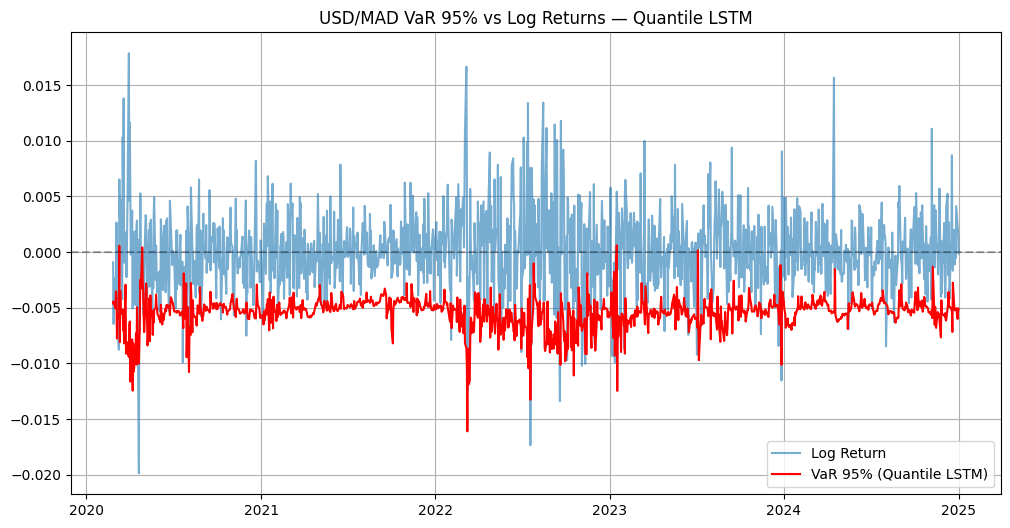

 Violations: 54
 Violation Rate: 4.27%
 Dernière date affichée : 2025-01-01T00:00:00.000000000

📊 Test d'indépendance des violations (Christoffersen)
Statistique LR : 0.2103
P-value         : 0.646543


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
df = pd.read_csv("/content/USD_MAD Historical Data (17).csv")
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values('Date')
df['Price'] = df['Price'].astype(float)
df['Log_Return'] = np.log(df['Price'] / df['Price'].shift(1))
df['Volatility_20d'] = df['Log_Return'].rolling(20).std()
df['EMA_10'] = df['Log_Return'].ewm(span=10).mean()
df = df[['Date', 'Log_Return', 'Volatility_20d', 'EMA_10']].dropna().reset_index(drop=True)
features = df[['Log_Return', 'Volatility_20d', 'EMA_10']].values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
returns_raw = df['Log_Return'].values.reshape(-1, 1)
SEQ_LEN = 20
X, y = [], []
for i in range(SEQ_LEN, len(features_scaled)):
    X.append(features_scaled[i-SEQ_LEN:i])
    y.append(returns_raw[i][0])
X = np.array(X)
y = np.array(y)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=5, shuffle=True)
class QuantileLSTM(nn.Module):
    def __init__(self, input_size=3, hidden_size=8, quantiles=[0.01, 0.025, 0.05]):
        super(QuantileLSTM, self).__init__()
        self.quantiles = quantiles
        self.input_fc = nn.Linear(input_size, 12)
        self.lstm = nn.LSTM(12, hidden_size, batch_first=True)
        self.output_layers = nn.ModuleList([nn.Linear(hidden_size, 1) for _ in quantiles])
    def forward(self, x):
        x = torch.relu(self.input_fc(x))
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return [layer(out).squeeze() for layer in self.output_layers]
def quantile_loss(preds, target, quantiles):
    loss = 0
    for i, q in enumerate(quantiles):
        errors = target - preds[i]
        loss += torch.mean(torch.max(q * errors, (q - 1) * errors))
    return loss
quantiles = [0.01, 0.025, 0.05]
model = QuantileLSTM(quantiles=quantiles)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 100
model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for xb, yb in loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = quantile_loss(preds, yb, quantiles)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss:.4f}")
model.eval()
with torch.no_grad():
    pred_quantiles = model(X_tensor)
    pred_005 = pred_quantiles[2].numpy()
dates = df['Date'].values[SEQ_LEN:]
returns_real = returns_raw[SEQ_LEN:].flatten()
plt.figure(figsize=(12,6))
plt.plot(dates, returns_real, label="Log Return", alpha=0.6)
plt.plot(dates, pred_005, label="VaR 95% (Quantile LSTM)", color='red')
plt.axhline(0, linestyle='--', color='black', alpha=0.3)
plt.title("USD/MAD VaR 95% vs Log Returns — Quantile LSTM")
plt.legend()
plt.grid()
plt.show()
violations = (returns_real < pred_005).sum()
violation_rate = violations / len(pred_005)
print(f" Violations: {violations}")
print(f" Violation Rate: {violation_rate:.2%}")
print(f" Dernière date affichée : {dates[-1]}")
import numpy as np
from scipy.stats import chi2

def christoffersen_independence_test(violations):
    n00 = n01 = n10 = n11 = 0

    for i in range(1, len(violations)):
        prev, curr = violations[i-1], violations[i]
        if prev == 0 and curr == 0:
            n00 += 1
        elif prev == 0 and curr == 1:
            n01 += 1
        elif prev == 1 and curr == 0:
            n10 += 1
        elif prev == 1 and curr == 1:
            n11 += 1

    pi0 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0.0001
    pi1 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0.0001
    pi = (n01 + n11) / (n00 + n01 + n10 + n11)

    L0 = ((n00 + n10) * np.log(1 - pi + 1e-10) + (n01 + n11) * np.log(pi + 1e-10))
    L1 = (n00 * np.log(1 - pi0 + 1e-10) + n01 * np.log(pi0 + 1e-10) +
          n10 * np.log(1 - pi1 + 1e-10) + n11 * np.log(pi1 + 1e-10))
    LR = -2 * (L0 - L1)
    p_value = 1 - chi2.cdf(LR, df=1)
    return round(LR, 4), round(p_value, 6)
violations_series = (returns_real < pred_005).astype(int)
lr_stat, p_val = christoffersen_independence_test(violations_series)
print("\n Test d'indépendance des violations (Christoffersen)")
print(f"Statistique LR : {lr_stat}")
print(f"P-value         : {p_val}")

